# tfdeepsurv for simulated data

## Introduction

Let's use `tfdeepsurv` package to build a neural network for predicting hazard ratio. This notebook 
will show you how to build and train a neural network.

## Preparation

For all things going well, you would be better to get acquainted with **Survival Analysis**. Otherwise, I suggest you read the [reference](https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html).

## Package installation

Please follow the instructions on [README](../README.md) to install `tfdeepsurv` package.

Install the package as below if use Colab.

```python
!git clone https://github.com/liupei101/TFDeepSurv.git TFDeepSurv
!pip install ./TFDeepSurv
```

## Get it started

### Obtain datasets 

In [1]:
from tfdeepsurv.datasets import load_simulated_data

### generate simulated data (Pandas.DataFrame)
# data configuration: 
#     hazard ratio = 2000
#     number of features = 10
#     number of valid features = 2

# No. of training data = 2000
train_data = load_simulated_data(2000, N=2000, num_var=2, num_features=10, seed=1)
# No. of training data = 800
test_data = load_simulated_data(2000, N=800, num_var=2, num_features=10, seed=1)

train_data.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,e,t
0,-0.165956,0.440649,-0.999771,-0.395335,-0.706488,-0.815323,-0.627480,-0.308879,-0.206465,0.077633,1,0.933961
1,-0.161611,0.370439,-0.591096,0.756235,-0.945225,0.340935,-0.165390,0.117380,-0.719226,-0.603797,1,0.242949
2,0.601489,0.936523,-0.373152,0.384645,0.752778,0.789213,-0.829912,-0.921890,-0.660339,0.756285,0,15.000000
3,-0.803306,-0.157785,0.915779,0.066331,0.383754,-0.368969,0.373002,0.669251,-0.963423,0.500289,0,15.000000
4,0.977722,0.496331,-0.439112,0.578559,-0.793548,-0.104213,0.817191,-0.412772,-0.424449,-0.739943,0,15.000000


### Dataset statistics

--------------- Survival Data Statistics ---------------
# Rows: 2000
# Columns: 10 + e + t
# Events Ratio: 0.74%
# Min Time: 0.00014043919509276748
# Max Time: 15.0



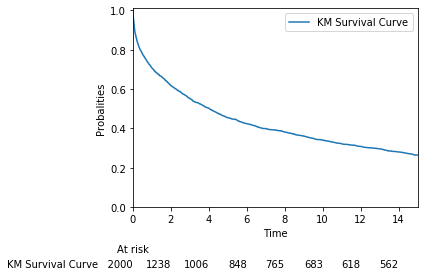

In [2]:
from tfdeepsurv.datasets import survival_stats

survival_stats(train_data, t_col="t", e_col="e", plot=True)

--------------- Survival Data Statistics ---------------
# Rows: 800
# Columns: 10 + e + t
# Events Ratio: 0.74%
# Min Time: 0.0005479883402585983
# Max Time: 15.0



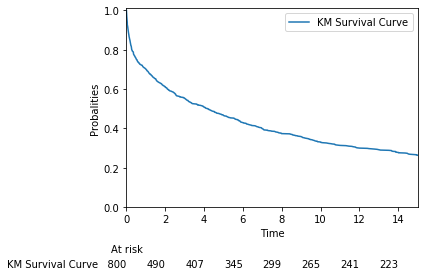

In [3]:
survival_stats(test_data, t_col="t", e_col="e", plot=True)

### Survival data transfrom

The transformed survival data contains an new label. Negative values are considered as right censored, 
and positive values are considered as event occurrence.

**NOTE**: In version 2.0, survival data must be transformed via `tfdeepsurv.datasets.survival_df`.

In [4]:
from tfdeepsurv.datasets import survival_df

surv_train = survival_df(train_data, t_col="t", e_col="e", label_col="Y")
surv_test = survival_df(test_data, t_col="t", e_col="e", label_col="Y")

# columns 't' and 'e' are packed into an new column 'Y'
surv_train.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,Y
0,-0.165956,0.440649,-0.999771,-0.395335,-0.706488,-0.815323,-0.627480,-0.308879,-0.206465,0.077633,0.933961
1,-0.161611,0.370439,-0.591096,0.756235,-0.945225,0.340935,-0.165390,0.117380,-0.719226,-0.603797,0.242949
2,0.601489,0.936523,-0.373152,0.384645,0.752778,0.789213,-0.829912,-0.921890,-0.660339,0.756285,-15.000000
3,-0.803306,-0.157785,0.915779,0.066331,0.383754,-0.368969,0.373002,0.669251,-0.963423,0.500289,-15.000000
4,0.977722,0.496331,-0.439112,0.578559,-0.793548,-0.104213,0.817191,-0.412772,-0.424449,-0.739943,-15.000000


### Model initialization

**NOTE:** You can freely change all hyper-parameters during model initialization or training as you want.

All hyper-parameters is as follows:
- `nn_config`: model configuration
- `hidden_layers_nodes`: hidden layers configuration
- `num_steps`: training steps

Hyperparameters tuning can refer to README in directory `byopt`.

In [5]:
from tfdeepsurv import dsnn

input_nodes = 10
hidden_layers_nodes = [6, 3, 1]

# the arguments of dsnn can be obtained by Bayesian Hyperparameters Tuning
nn_config = {
    "learning_rate": 0.7,
    "learning_rate_decay": 1.0,
    "activation": 'relu', 
    "L1_reg": 3.4e-5, 
    "L2_reg": 8.8e-5, 
    "optimizer": 'sgd',
    "dropout_keep_prob": 1.0,
    "seed": 1
}
# ESSENTIAL STEP: Pass arguments
model = dsnn(
    input_nodes, 
    hidden_layers_nodes,
    nn_config
)
# ESSENTIAL STEP: Build Computation Graph
model.build_graph()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


### Model training

You can save your trained model by passing `save_model="file_name.ckpt"` or load your trained model by passing `load_model="file_name.ckpt"`

In [1]:
Y_col = ["Y"]
X_cols = [c for c in surv_train.columns if c not in Y_col]

# model saving and loading is also supported!
# read comments of `train()` function if necessary.
watch_list = model.train(
    surv_train[X_cols], surv_train[Y_col],
    num_steps=1900,
    num_skip_steps=100,
    plot=True
)

NameError: name 'surv_train' is not defined

### Model evaluation

In [7]:
print("CI on training data:", model.evals(surv_train[X_cols], surv_train[Y_col]))
print("CI on test data:", model.evals(surv_test[X_cols], surv_test[Y_col]))

CI on training data: 0.8193206851448683
CI on test data: 0.8175830825866967


### Model prediction

Model prediction includes:
- predicting hazard ratio or log hazard ratio
- predicting survival function

In [8]:
# predict log hazard ratio
print(model.predict(surv_test.loc[0:4, X_cols]))
# predict hazard ratio
print(model.predict(surv_test.loc[0:4, X_cols], output_margin=False))

[[4.629786 ]
 [4.8222055]
 [0.       ]
 [1.4019105]
 [0.       ]]
[[102.49213 ]
 [124.2388  ]
 [  1.      ]
 [  4.062955]
 [  1.      ]]


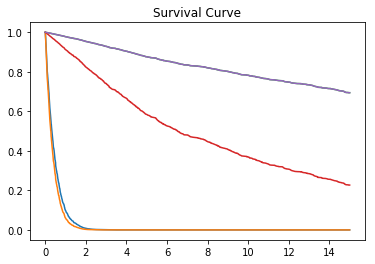

,0.00014043919509276748,0.00039331152220256627,0.00126435118727386,0.0027157075237482786,0.002904581604525447,0.0030980780720710754,0.003499445738270879,0.0036616716533899307,0.004621267784386873,0.004637269768863916,...,14.737560272216797,14.74014663696289,14.750370979309082,14.778524398803711,14.781179428100586,14.794774055480957,14.816924095153809,14.933478355407715,14.945713996887207,15.0
0,0.999388,0.998775,0.998159,0.997543,0.996925,0.996304,0.995678,0.995050,0.994421,0.993786,...,1.230686e-16,1.117655e-16,1.014383e-16,9.202992e-17,8.347148e-17,7.569418e-17,6.862914e-17,6.220573e-17,5.636893e-17,5.636893e-17
1,0.999258,0.998515,0.997769,0.997023,0.996274,0.995521,0.994763,0.994003,0.993241,0.992472,...,5.180973e-20,4.609930e-20,4.098780e-20,3.642605e-20,3.236135e-20,2.874343e-20,2.552441e-20,2.265803e-20,2.010723e-20,2.010723e-20
2,0.999994,0.999988,0.999982,0.999976,0.999970,0.999964,0.999958,0.999952,0.999945,0.999939,...,6.994715e-01,6.988143e-01,6.981536e-01,6.974908e-01,6.968269e-01,6.961623e-01,6.954970e-01,6.948305e-01,6.941629e-01,6.941629e-01
3,0.999976,0.999951,0.999927,0.999902,0.999878,0.999853,0.999828,0.999803,0.999778,0.999753,...,2.340494e-01,2.331573e-01,2.322629e-01,2.313684e-01,2.304749e-01,2.295830e-01,2.286930e-01,2.278038e-01,2.269158e-01,2.269158e-01
4,0.999994,0.999988,0.999982,0.999976,0.999970,0.999964,0.999958,0.999952,0.999945,0.999939,...,6.994715e-01,6.988143e-01,6.981536e-01,6.974908e-01,6.968269e-01,6.961623e-01,6.954970e-01,6.948305e-01,6.941629e-01,6.941629e-01


In [9]:
# predict survival function
model.predict_survival_function(surv_test.loc[0:4, X_cols], plot=True)

### tf.session close

To release resources, we use `model.close_session()` to close session in tensorflow!

In [10]:
model.close_session()

Current session closed.
